In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import torch
from torch import nn
from easy_tpp.preprocess.event_tokenizer import EventTokenizer
from easy_tpp.config_factory import DataSpecConfig
from models.encoders.gru import GRUTPPEncoder
from models.decoders.rmtpp import RMTPPDecoder, RMTPPLoss
from models import TPPModel, VAETPPModel
from torch.utils.data import DataLoader, Dataset
from utils.evaluatetpp import evaluate_tpp_model, evaluate_vae_model, calculate_event_metrics
from scipy import integrate
from scipy.stats import gaussian_kde
from sklearn.manifold import TSNE
import scienceplots
plt.style.use(['science'])

In [2]:
def preprocess_data(raw_data):
    # Validate input
    if not raw_data:
        raise ValueError("Input data is empty")
        
    # Create input data dictionary
    input_data = {
        'time_seqs': [[x["time_since_start"] for x in seq] for seq in raw_data],
        'type_seqs': [[x["type_event"] for x in seq] for seq in raw_data],
        'time_delta_seqs': [[x["time_since_last_event"] for x in seq] for seq in raw_data]
    }

    filtered_data = {
        k: [seq for seq in v if len(seq) > 0]
        for k, v in input_data.items()
    }
    
    if not filtered_data['type_seqs']:
        raise ValueError("No valid sequences found after filtering (all sequences were empty)")
        
    return filtered_data

def collate_fn(batch, config):
    tokenizer = EventTokenizer(config)
    tokenizer.padding_side = 'right'
    seq_lengths = [batch_item['sequence_length'] for batch_item in batch]  
    padded_batch = tokenizer.pad(batch, 
                                 return_tensors='pt',
                                 return_attention_mask=None,
                                 padding='longest')
    padded_batch['sequence_length'] = torch.tensor(seq_lengths)
    
    return padded_batch

In [3]:
class EventDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data['type_seqs'])

    def __getitem__(self, idx):
        return {
            'time_seqs': self.data['time_seqs'][idx],
            'type_seqs': self.data['type_seqs'][idx],
            'time_delta_seqs': self.data['time_delta_seqs'][idx],
            'sequence_length': len(self.data['type_seqs'][idx])
        }

In [4]:
def plot_event_sequence(time_seqs, type_seqs, time_delta_seqs, sequence_length, calculated_deltas, decoder_output, num_samples=5):
    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()
        pred_time_delta_seq = calculated_deltas[i].detach().cpu().numpy() if calculated_deltas is torch.Tensor else calculated_deltas
        pred_mark_logits = decoder_output.mark_logits[i].detach().cpu().numpy()

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.plot(time_seq[:seq_len], type_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], np.argmax(pred_mark_logits[:seq_len], axis=-1), 'o-', label='Predicted')
        plt.xlabel('Time')
        plt.ylabel('Event Type')
        plt.title('Event Sequence')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(time_seq[:seq_len], time_delta_seq[:seq_len], 'o-', label='True')
        plt.plot(time_seq[:seq_len], pred_time_delta_seq[:seq_len], 'o-', label='Calculated')
        plt.xlabel('Time')
        plt.ylabel('Time Delta')
        plt.title('Time Delta Sequence')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [5]:
dev_dict = pkl.load(open('data/taxi/dev.pkl', 'rb'))
test_dict = pkl.load(open('data/taxi/test.pkl', 'rb'))
train_dict = pkl.load(open('data/taxi/train.pkl', 'rb'))

train_data = train_dict['train']
test_data = test_dict['test']
dev_data = dev_dict['dev']

In [6]:
dim_process = train_dict['dim_process']
config = DataSpecConfig.parse_from_yaml_config({
    'num_event_types': dim_process,
    'pad_token_id': dim_process
})

In [7]:
# Create datasets
preprocessed_train = preprocess_data(train_data)
preprocessed_test = preprocess_data(test_data)

train_dataset = EventDataset(preprocessed_train)
test_dataset = EventDataset(preprocessed_test)

# Create data loaders with collate function and arguments to prepare_data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=lambda batch: collate_fn(batch, config), drop_last=False)

In [8]:
HIDDEN_DIM = 128
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

tpp_model = TPPModel(config, hidden_dim=HIDDEN_DIM, mlp_dim=MLP_DIM, device=device).to(device)

# Training loop
num_epochs = 200
optimizer = torch.optim.Adam(tpp_model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    tpp_model.train()
    total_train_loss = 0
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        decoder_output = tpp_model(batch)
        time_loss, mark_loss, total_loss = tpp_model.compute_loss(batch, decoder_output)
        total_loss.backward()
        optimizer.step()
        total_train_loss += total_loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    # Evaluate on test data
    tpp_model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            decoder_output = tpp_model(batch)
            _, _, total_loss = tpp_model.compute_loss(batch, decoder_output)
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")

Epoch 1/200, Train Loss: 1.0701
Epoch 1/200, Test Loss: 0.6329
Epoch 2/200, Train Loss: 0.4729
Epoch 2/200, Test Loss: 0.0754
Epoch 3/200, Train Loss: -0.1854
Epoch 3/200, Test Loss: -0.3727
Epoch 4/200, Train Loss: -0.4384
Epoch 4/200, Test Loss: -0.5650
Epoch 5/200, Train Loss: -0.5990
Epoch 5/200, Test Loss: -0.6924
Epoch 6/200, Train Loss: -0.7165
Epoch 6/200, Test Loss: -0.8027
Epoch 7/200, Train Loss: -0.8050
Epoch 7/200, Test Loss: -0.8908
Epoch 8/200, Train Loss: -0.8931
Epoch 8/200, Test Loss: -0.9701
Epoch 9/200, Train Loss: -0.9386
Epoch 9/200, Test Loss: -1.0191
Epoch 10/200, Train Loss: -1.0151
Epoch 10/200, Test Loss: -1.0678
Epoch 11/200, Train Loss: -1.0569
Epoch 11/200, Test Loss: -1.1044
Epoch 12/200, Train Loss: -1.0887
Epoch 12/200, Test Loss: -1.1270
Epoch 13/200, Train Loss: -1.1243
Epoch 13/200, Test Loss: -1.1647
Epoch 14/200, Train Loss: -1.1549
Epoch 14/200, Test Loss: -1.1904
Epoch 15/200, Train Loss: -1.1842
Epoch 15/200, Test Loss: -1.2205
Epoch 16/200, Tra

In [9]:
tpp_eval_metrics = evaluate_tpp_model(tpp_model, test_loader, config, device=device)

/Users/heqingyin/Desktop/ProbabilisticTPP/utils/evaluatetpp.py:96: RuntimeWarning: overflow encountered in exp
  - np.exp(
/Users/heqingyin/Desktop/ProbabilisticTPP/utils/evaluatetpp.py:88: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  expected_next_time = integrate.quad(


In [10]:
tpp_eval_metrics

{'time_mae': np.float32(0.027417349),
 'time_rmse': np.float32(0.038264148),
 'event_accuracy': np.float64(0.9997975708502024),
 'event_total': 14820,
 'type_metrics': {'type_0': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_1': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_2': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_3': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_4': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_5': {'precision': np.float64(0.9982014388489209),
   'recall': np.float64(1.0),
   'f1': np.float64(0.9990999099909991)},
  'type_6': {'precision': np.float64(1.0),
   'recall': np.float64(1.0),
   'f1': np.float64(1.0)},
  'type_7': {'precision': np.float64(0.6),
   'recall': np.float64(1.0),
   'f1': np.float64(0.74999999

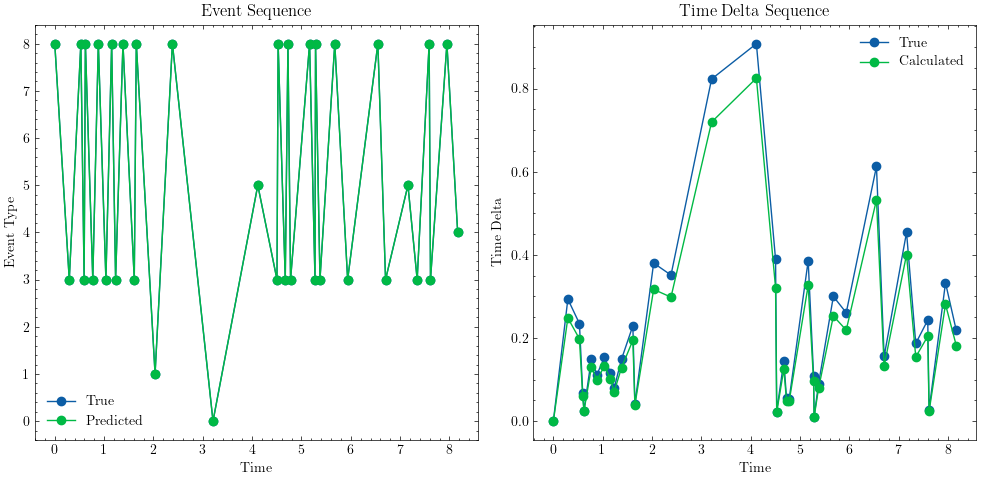

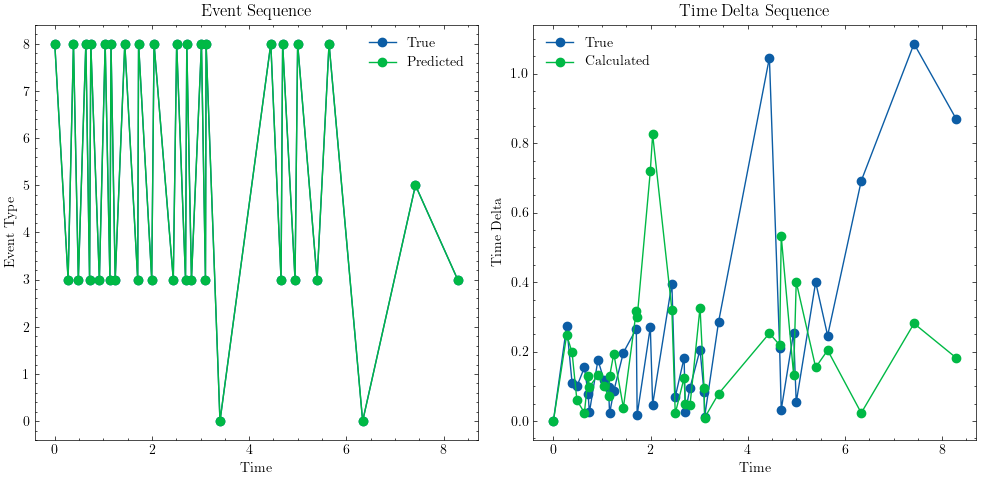

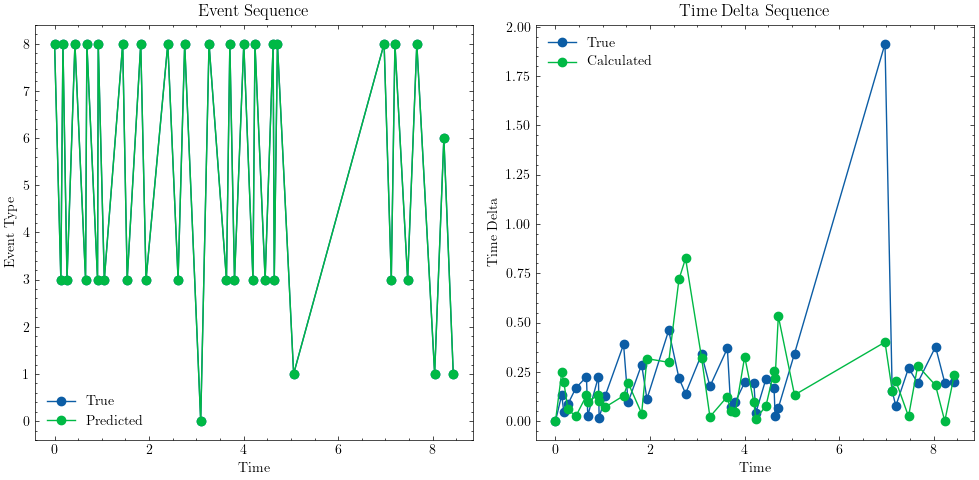

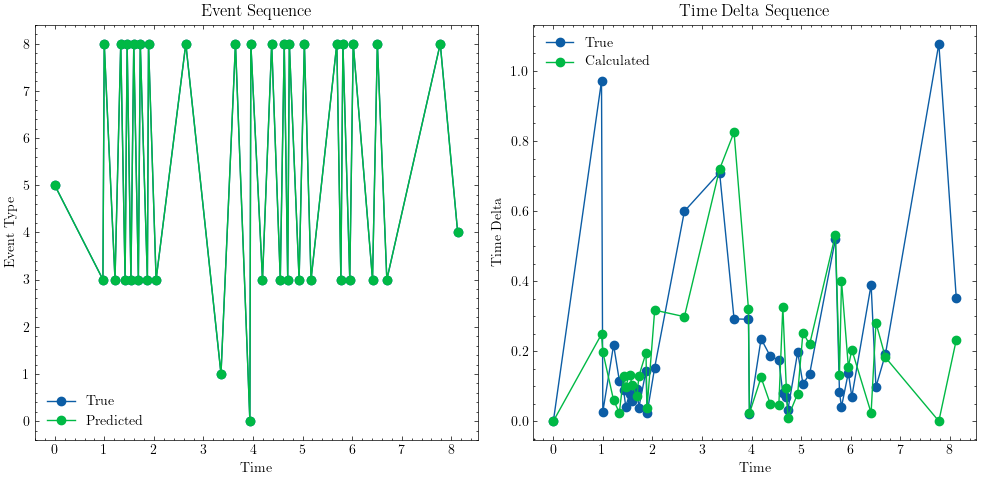

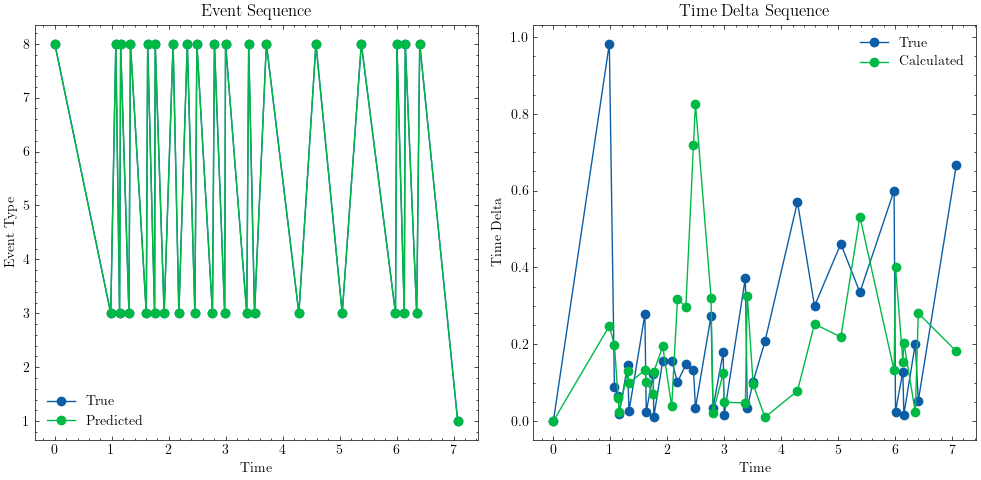

In [11]:
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = tpp_model(batch)
    plot_event_sequence(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        tpp_eval_metrics['predicted_intervals'], 
        decoder_output
    )
    break

In [12]:
# reload VAETPPModel
import importlib
import models
importlib.reload(models)
from models import TPPModel, VAETPPModel

HIDDEN_DIM = 128
LATENT_DIM = 32
MLP_DIM = 64
device = 'cpu' if not torch.cuda.is_available() else 'cuda'

# calculate the number of steps for beta annealing and warmup
num_epochs = 200
num_steps = len(train_loader) * num_epochs
cyclic_steps = num_steps // 5
warmup_steps = len(train_loader) * 20

vae_model = VAETPPModel(config, hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM, mlp_dim=MLP_DIM, device=device, beta_steps=num_steps, warmup_steps=warmup_steps, beta_start=0, beta_end=0.5, l1_lambda=0.000, l2_lambda=0.000).to(device)
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

# One cycle learning rate scheduler
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=num_epochs,
    anneal_strategy='cos',
)

# Training loop with beta annealing
for epoch in range(num_epochs):
    vae_model.train()
    total_train_loss = 0
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        decoder_output = vae_model(batch)
        time_loss, mark_loss, total_loss = vae_model.compute_loss(batch, decoder_output)
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        total_train_loss += total_loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}")

    vae_model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            decoder_output = vae_model(batch)
            _, _, total_loss = vae_model.compute_loss(batch, decoder_output)
            total_test_loss += total_loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Test Loss: {avg_test_loss:.4f}")


Epoch 1/200, Train Loss: 2.5608
Epoch 1/200, Test Loss: 2.4805
Epoch 2/200, Train Loss: 2.4074
Epoch 2/200, Test Loss: 2.3140
Epoch 3/200, Train Loss: 2.2100
Epoch 3/200, Test Loss: 2.0687
Epoch 4/200, Train Loss: 1.9079
Epoch 4/200, Test Loss: 1.7155
Epoch 5/200, Train Loss: 1.5548
Epoch 5/200, Test Loss: 1.3703
Epoch 6/200, Train Loss: 1.2556
Epoch 6/200, Test Loss: 1.1182
Epoch 7/200, Train Loss: 1.0555
Epoch 7/200, Test Loss: 0.9593
Epoch 8/200, Train Loss: 0.9282
Epoch 8/200, Test Loss: 0.8534
Epoch 9/200, Train Loss: 0.8401
Epoch 9/200, Test Loss: 0.7779
Epoch 10/200, Train Loss: 0.7791
Epoch 10/200, Test Loss: 0.7267
Epoch 11/200, Train Loss: 0.7361
Epoch 11/200, Test Loss: 0.6920
Epoch 12/200, Train Loss: 0.7047
Epoch 12/200, Test Loss: 0.6655
Epoch 13/200, Train Loss: 0.6776
Epoch 13/200, Test Loss: 0.6406
Epoch 14/200, Train Loss: 0.6497
Epoch 14/200, Test Loss: 0.5834
Epoch 15/200, Train Loss: 0.5075
Epoch 15/200, Test Loss: 0.4213
Epoch 16/200, Train Loss: 0.3990
Epoch 16/2

In [13]:
vae_eval_metrics = evaluate_vae_model(vae_model, test_loader, config, device=device)

In [14]:
# vae_eval_metrics

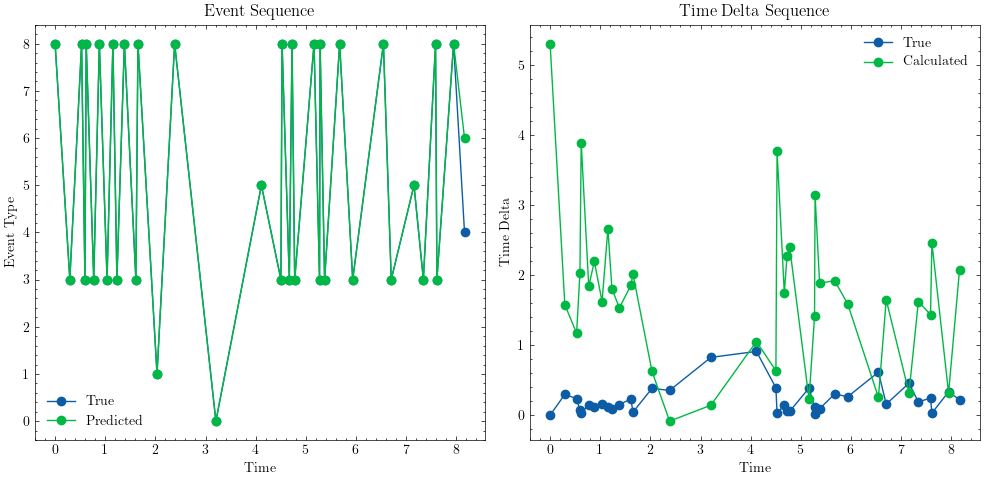

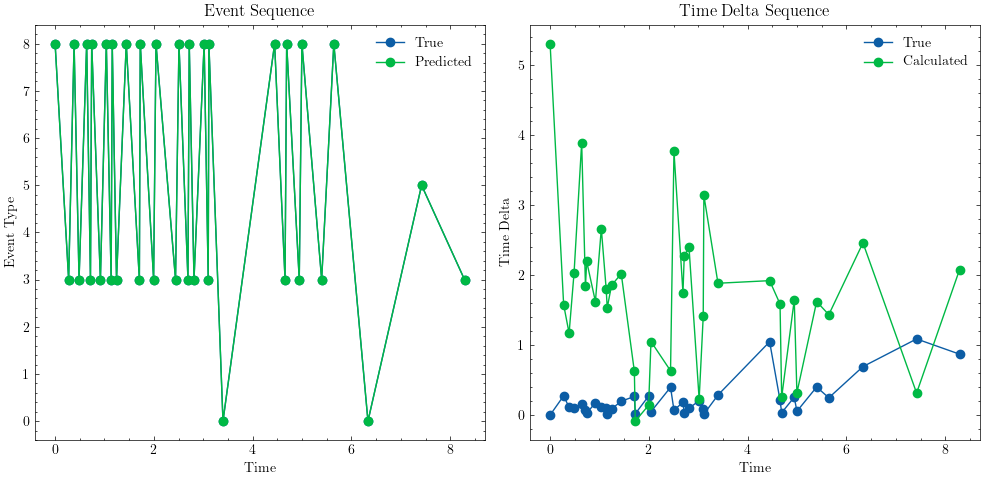

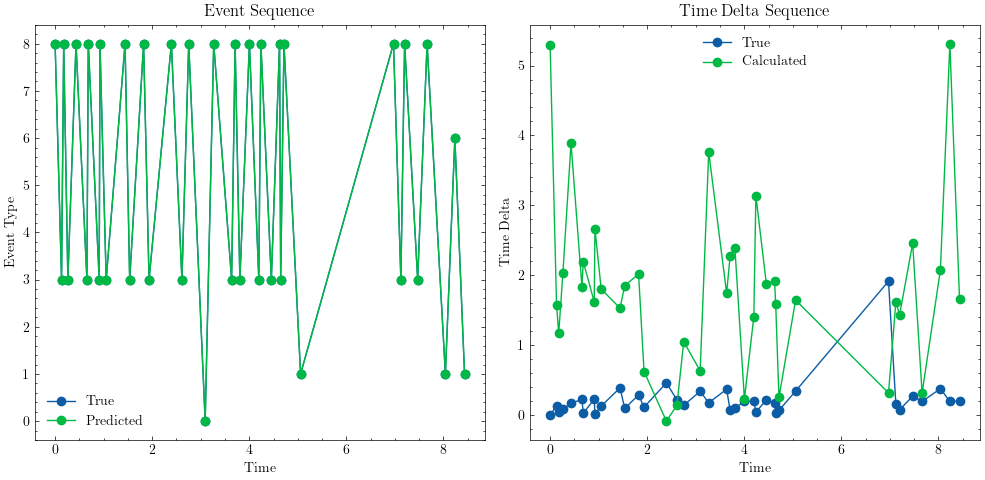

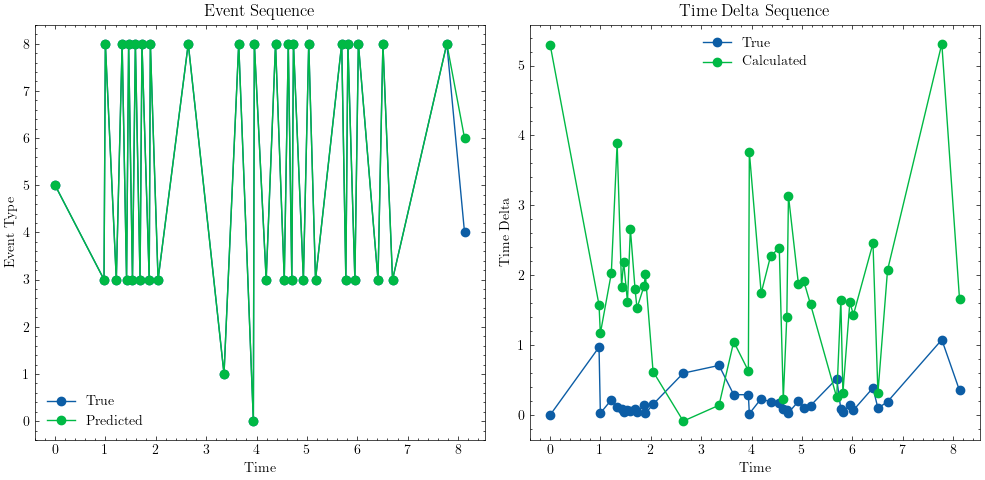

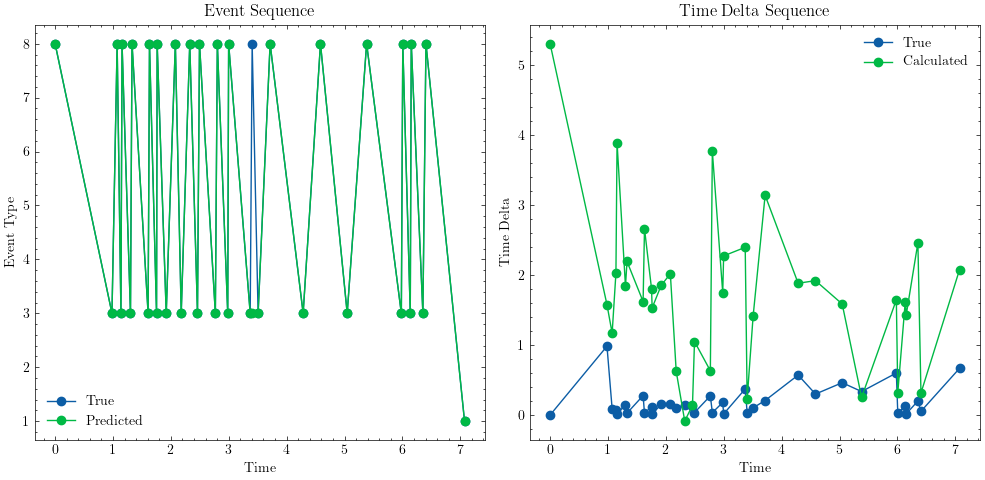

In [15]:
# plot the event sequences and the predicted event sequences
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    decoder_output = vae_model(batch)
    plot_event_sequence(
        batch['time_seqs'], 
        batch['type_seqs'], 
        batch['time_delta_seqs'], 
        batch['sequence_length'], 
        vae_eval_metrics['predicted_intervals'], 
        decoder_output
    )
    break

In [16]:
def plot_event_sequence_with_intensity(
    time_seqs,
    type_seqs,
    time_delta_seqs,
    sequence_length,
    tpp_eval_metrics,
    vae_eval_metrics,
    decoder_output_tpp,
    decoder_output_vae,
    num_samples=5,
):
    """
    Plot event sequences and compare deterministic vs probabilistic intensity functions.

    Args:
        time_seqs (torch.Tensor): Ground truth event times.
        type_seqs (torch.Tensor): Ground truth event types.
        time_delta_seqs (torch.Tensor): Ground truth time deltas.
        sequence_length (torch.Tensor): Sequence lengths.
        tpp_eval_metrics (dict): Evaluation metrics from the TPP model.
        vae_eval_metrics (dict): Evaluation metrics from the VAE model.
        decoder_output_tpp (object): Decoder output from TPP model.
        decoder_output_vae (object): Decoder output from VAE model.
        num_samples (int): Number of sequences to plot.
    """
    predicted_intervals_tpp = tpp_eval_metrics["predicted_intervals"]
    predicted_intervals_vae = vae_eval_metrics["predicted_intervals"]

    for i in range(num_samples):
        time_seq = time_seqs[i].detach().cpu().numpy()
        type_seq = type_seqs[i].detach().cpu().numpy()
        time_delta_seq = time_delta_seqs[i].detach().cpu().numpy()
        seq_len = sequence_length[i].item()

        pred_time_delta_tpp = (
            predicted_intervals_tpp[i].detach().cpu().numpy()
            if isinstance(predicted_intervals_tpp, torch.Tensor)
            else predicted_intervals_tpp
        )
        pred_time_delta_vae = (
            predicted_intervals_vae[i].detach().cpu().numpy()
            if isinstance(predicted_intervals_vae, torch.Tensor)
            else predicted_intervals_vae
        )

        pred_event_types_tpp = torch.argmax(decoder_output_tpp.mark_logits[i], dim=-1).detach().cpu().numpy()
        pred_event_types_vae = torch.argmax(decoder_output_vae.mark_logits[i], dim=-1).detach().cpu().numpy()

        plt.figure(figsize=(18, 10))
        plt.subplot(2, 2, 1)
        plt.plot(time_seq[:seq_len], type_seq[:seq_len], "o-", label="True")
        plt.plot(
            time_seq[:seq_len],
            pred_event_types_tpp[:seq_len],
            "o-",
            label="TPP Predicted",
        )
        plt.plot(
            time_seq[:seq_len],
            pred_event_types_vae[:seq_len],
            "o-",
            label="VAE Predicted",
        )
        plt.xlabel("Time")
        plt.ylabel("Event Type")
        plt.title("Event Sequence")
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(time_seq[:seq_len], time_delta_seq[:seq_len], "o-", label="True")
        plt.plot(
            time_seq[:seq_len],
            pred_time_delta_tpp[:seq_len],
            "o-",
            label="TPP Predicted",
        )
        plt.plot(
            time_seq[:seq_len],
            pred_time_delta_vae[:seq_len],
            "o-",
            label="VAE Predicted",
        )
        plt.xlabel("Time")
        plt.ylabel("Time Delta")
        plt.title("Time Delta Sequence")
        plt.legend()


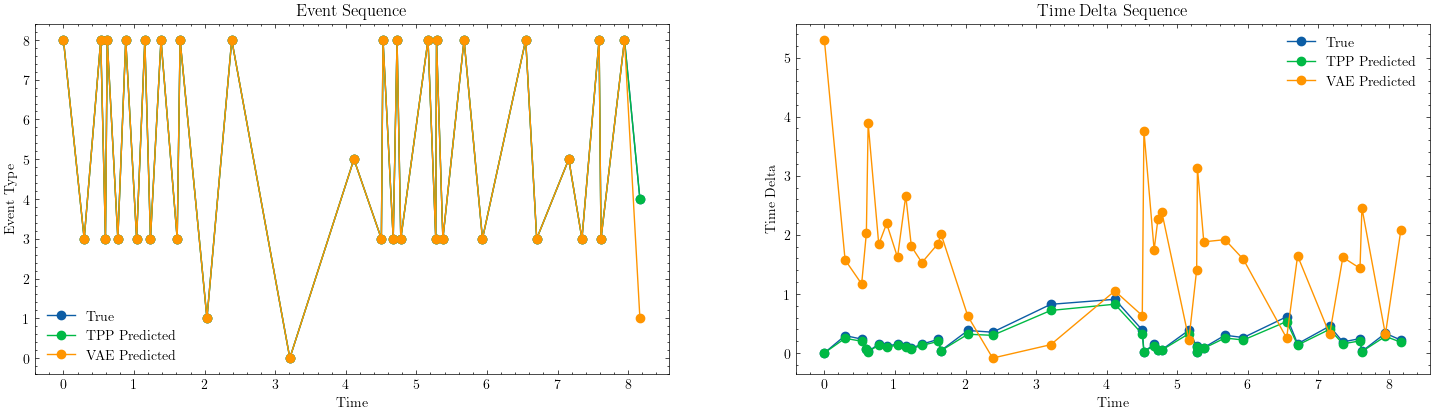

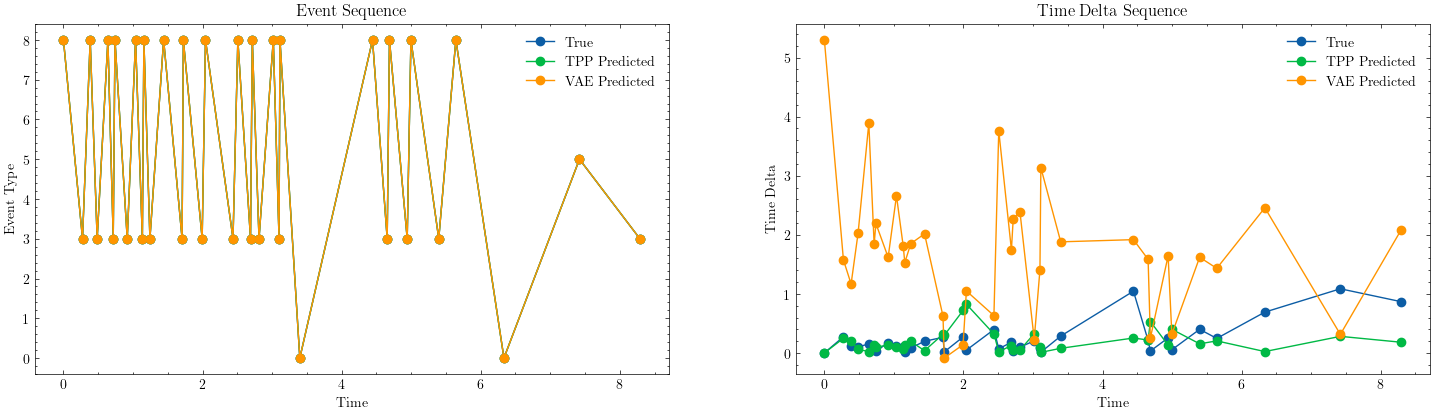

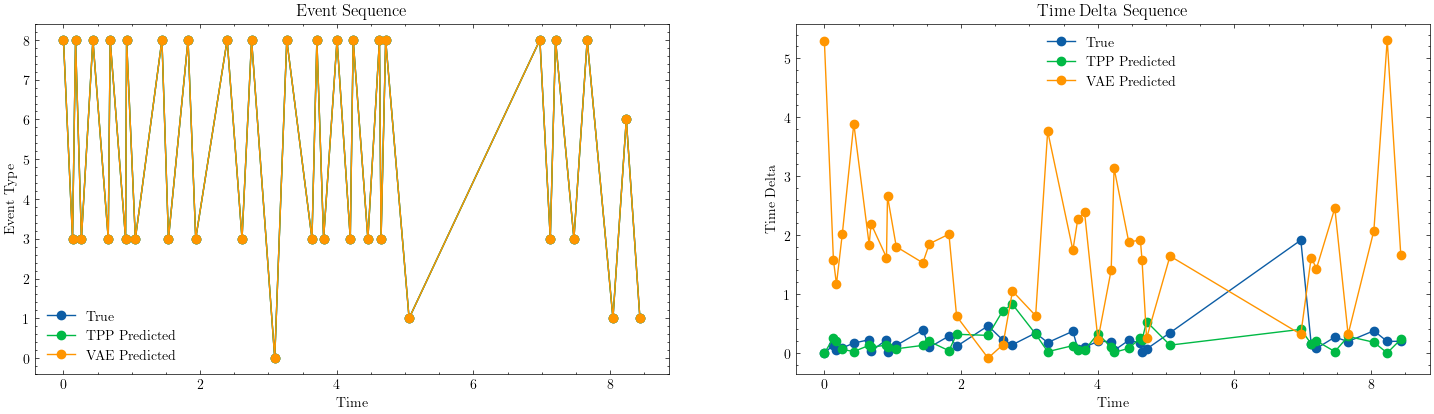

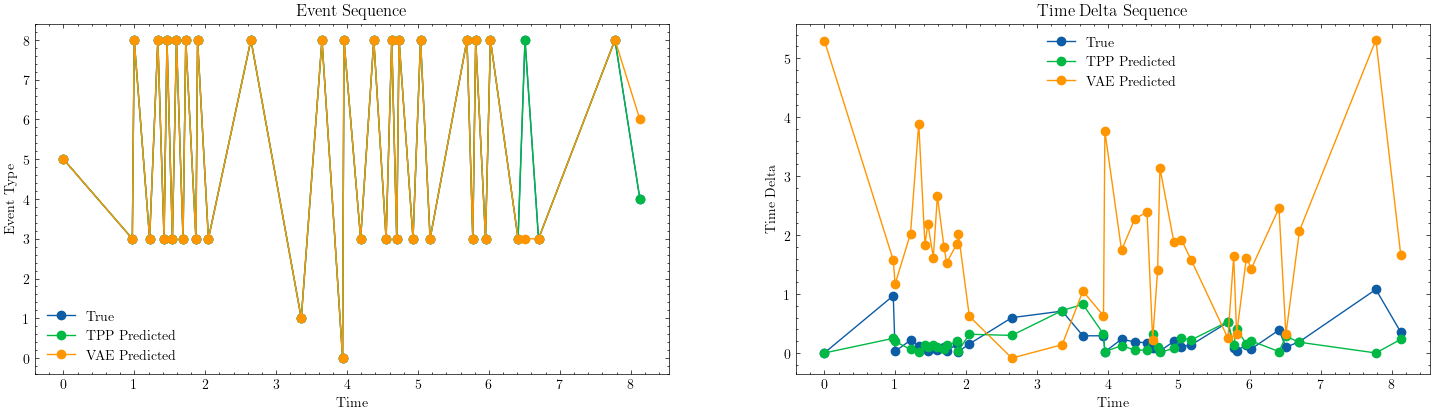

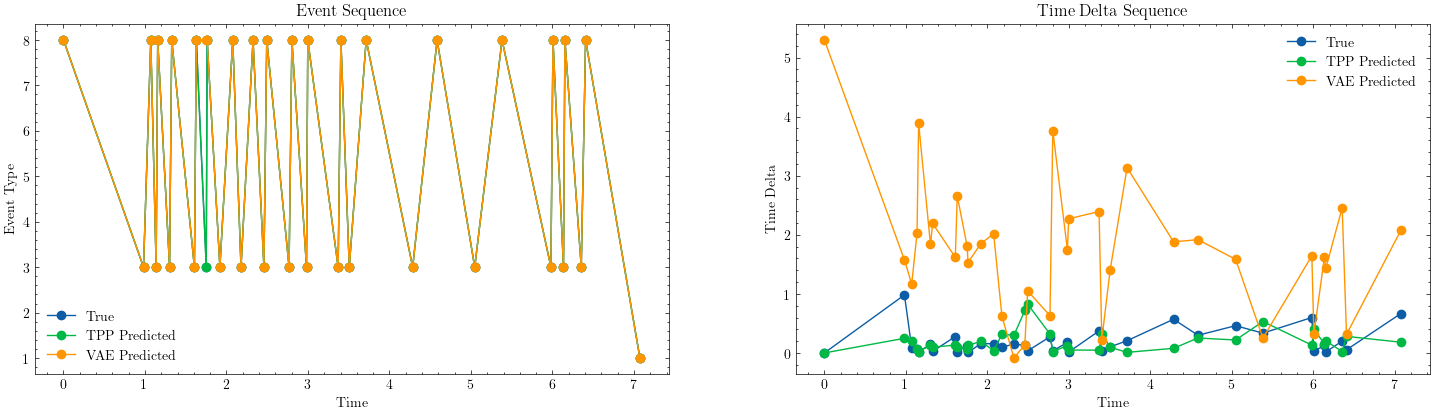

In [17]:
for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}

    decoder_output_tpp = tpp_model(batch)
    decoder_output_vae = vae_model(batch)

    plot_event_sequence_with_intensity(
        batch["time_seqs"],
        batch["type_seqs"],
        batch["time_delta_seqs"],
        batch["sequence_length"],
        tpp_eval_metrics,
        vae_eval_metrics,
        decoder_output_tpp,
        decoder_output_vae,
    )
    break

In [22]:
def plot_latent_space(model, data_loader, device):
    """
    Plot latent space of the VAE model using mu from the forward pass, excluding padding tokens.

    Args:
        model (VAETPPModel): VAE model.
        data_loader (DataLoader): Data loader.
        device (str): Device to run the model on.
    """
    model.eval()
    mus = []
    event_types = []
    masks = []

    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            output = model(batch)
            mu = output.mu
            
            # Create mask for padding tokens
            sequence_lengths = batch["sequence_length"]
            batch_mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
            
            # Reshape mu and event types if they have sequence dimension
            if len(mu.shape) > 2:
                mu = mu.reshape(-1, mu.shape[-1])
                batch_mask = batch_mask.reshape(-1)
            
            mus.append(mu)
            event_types.append(batch["type_seqs"].reshape(-1))
            masks.append(batch_mask)
            
            print("Shape of mu:", mu.shape)
            print("Shape of mask:", batch_mask.shape)
    
    # Concatenate all batches
    mus = torch.cat(mus, dim=0).cpu().numpy()
    event_types = torch.cat(event_types, dim=0).cpu().numpy()
    masks = torch.cat(masks, dim=0).cpu().numpy()
    
    print("Shape before masking:")
    print("mus:", mus.shape)
    print("event_types:", event_types.shape)
    print("masks:", masks.shape)
    
    # Apply mask to filter out padding tokens
    mus = mus[masks]
    event_types = event_types[masks]
    
    print("\nShape after masking:")
    print("mus:", mus.shape)
    print("event_types:", event_types.shape)
    
    # Reduce dimensionality using t-SNE    
    tsne = TSNE(n_components=2, random_state=0)
    mus = tsne.fit_transform(mus)
    
    # Make color discrete map using default rc colormap
    unique_event_types = np.unique(event_types)
    # colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    colors = plt.cm.tab20.colors
    color_map = {event_type: colors[i % len(colors)] for i, event_type in enumerate(unique_event_types)}
    
    # Create visualization
    plt.figure(figsize=(10, 10))
    
    # Create list of colors for each point
    point_colors = [color_map[int(et)] for et in event_types]
    
    scatter = plt.scatter(mus[:, 0], mus[:, 1], c=point_colors, alpha=0.6)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space of VAETPP Model (Excluding Padding)")
    
    # Add legend
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                                markerfacecolor=color_map[et], label=f'Event {et}',
                                markersize=10)
                      for et in unique_event_types]
    plt.legend(handles=legend_elements, title="Event Types", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

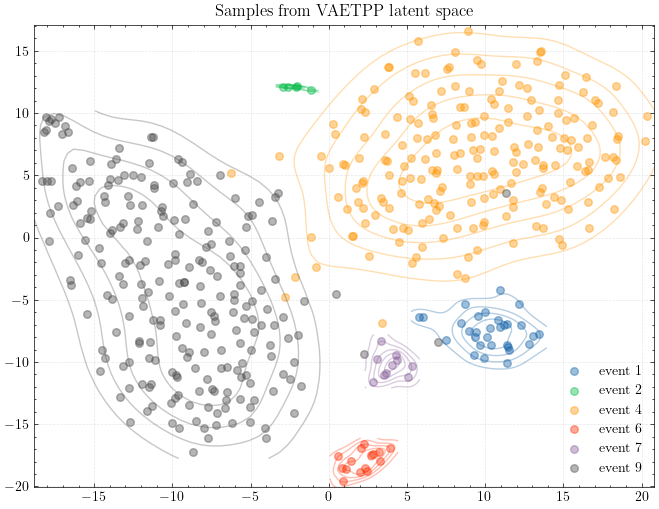

In [19]:
def visualize_vae_latent_space(model, data_loader, device, max_samples=100):
    model.eval()
    
    batch = next(iter(data_loader))
    batch = {k: v.to(device) for k, v in batch.items()}
    sequence_lengths = batch["sequence_length"].to(device)
    
    # identify the padding tokens
    mask = torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device) < sequence_lengths.unsqueeze(1)
    mask = mask.cpu().numpy()
    
    with torch.no_grad():
        output = model(batch)
        mu = output.mu.cpu().numpy()
        logvar = output.logvar.cpu().numpy()
        event_types = batch["type_seqs"].cpu().numpy()
        
        mu = mu[mask].reshape(-1, mu.shape[-1])
        logvar = logvar[mask].reshape(-1, logvar.shape[-1])
        event_types = event_types[mask].reshape(-1)
        
        if len(mu) > max_samples:
            idx = np.random.choice(len(mu), max_samples, replace=False)
            mu = mu[idx]
            logvar = logvar[idx]
            event_types = event_types[idx]
    
    std = np.exp(0.5 * logvar)
    n_samples_per_point = 5
    samples = []
    sample_types = []
    
    for i in range(len(mu)):
        for _ in range(n_samples_per_point):
            sample = mu[i] + np.random.randn(*mu[i].shape) * std[i]
            samples.append(sample)
            sample_types.append(event_types[i])
    
    samples = np.stack(samples)
    sample_types = np.array(sample_types)
    
    tsne = TSNE(n_components=2, random_state=42)
    samples_2d = tsne.fit_transform(samples)
    
    plt.figure(figsize=(8, 6))
    
    # Get default color cycle
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    for idx, event_type in enumerate(np.unique(event_types)):
        mask = sample_types == event_type
        points = samples_2d[mask]
        
        kde = gaussian_kde(points.T)
        x_min, x_max = points[:, 0].min() - 0.5, points[:, 0].max() + 0.5
        y_min, y_max = points[:, 1].min() - 0.5, points[:, 1].max() + 0.5
        
        x = np.linspace(x_min, x_max, 50)
        y = np.linspace(y_min, y_max, 50)
        X, Y = np.meshgrid(x, y)
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = kde(positions).reshape(X.shape)
        
        color = colors[idx % len(colors)]
        label = f'event {event_type + 1}'
        
        plt.contour(X, Y, Z, levels=5, colors=color, alpha=0.3)
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.4, label=label, s=30)
    
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.title('Samples from VAETPP latent space')
    
    return plt.gcf()

# Usage
fig = visualize_vae_latent_space(vae_model, test_loader, device, max_samples=100)
plt.show()

Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([1216, 32])
Shape of mask: torch.Size([1216])
Shape of mu: torch.Size([608, 32])
Shape of mask: torch.Size([608])
Shape before masking:
mus: (15200, 32)
event_types: (15200,)
masks: (15200,)

Shape after ma

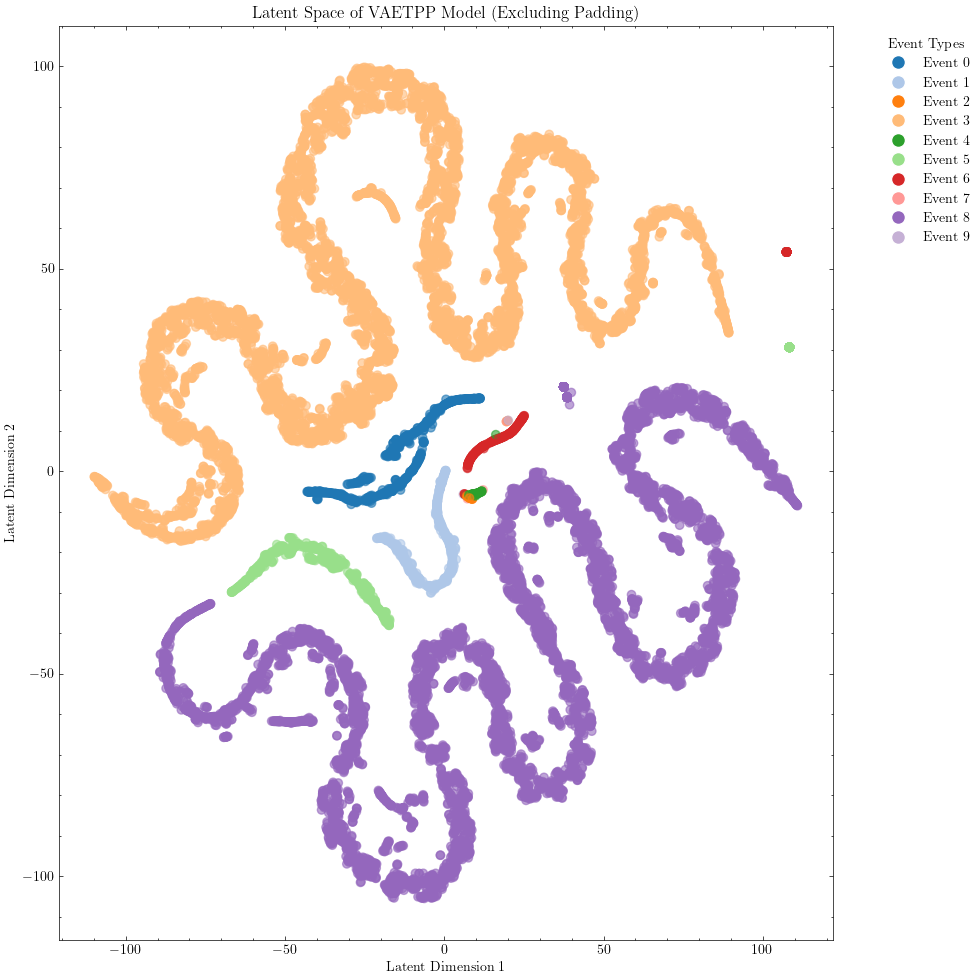

In [23]:
plot_latent_space(vae_model, test_loader, device)

In [ ]:
# def cosine_annealing_schedule(
#     step: int,
#     n_steps: int,
#     beta_start: float,
#     beta_end: float,
#     warmup_steps: int,
# ) -> float:
#     """Cyclic cosine annealing schedule for beta."""
#     if step <= warmup_steps:
#         return beta_start
#     else:
#         cycle_step = (step - warmup_steps) % n_steps
#         progress = cycle_step / n_steps
#         return beta_end + 0.5 * (beta_start - beta_end) * (
#             1 + torch.cos(torch.tensor(progress * 3.141592653589793))
#         )
        
# # Visualize the schedule
# warmup_steps = 40
# steps = np.arange(0, num_steps)
# betas = [cosine_annealing_schedule(step, num_steps // 5, 0, 0.5, warmup_steps) for step in steps]

# plt.figure(figsize=(10, 5))
# plt.plot(steps, betas, label='Beta Schedule')
# plt.xlabel('Steps')
# plt.ylabel('Beta')
# plt.title('Cosine Annealing Schedule for Beta')
# plt.legend()
# plt.show()

In [50]:
def plot_latent_space_tpp(model, data_loader, device):
    """
    Plot latent space for TPP models using hidden states, excluding padding tokens.

    Args:
        model (nn.Module): TPP model (e.g., RMTPPModel).
        data_loader (torch.utils.data.DataLoader): Data loader for input batches.
        device (torch.device): Device to run the model on.
    """
    model.eval()
    latent_representations = []
    event_types = []
    masks = []

    with torch.no_grad():
        for batch in data_loader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            
            # Forward pass to get hidden states
            hidden_states = model.encoder(batch)  # Extract hidden states from encoder
            
            # Create mask to exclude padding tokens
            sequence_lengths = batch["sequence_length"]
            batch_mask = (
                torch.arange(batch["type_seqs"].size(1)).unsqueeze(0).to(device)
                < sequence_lengths.unsqueeze(1)
            )
            
            # Reshape hidden states and masks if they have a sequence dimension
            if len(hidden_states.shape) > 2:  # If hidden states are [batch_size, seq_len, hidden_dim]
                hidden_states = hidden_states.reshape(-1, hidden_states.shape[-1])
                batch_mask = batch_mask.reshape(-1)
            
            latent_representations.append(hidden_states)
            event_types.append(batch["type_seqs"].reshape(-1))
            masks.append(batch_mask)
    
    # Concatenate all batches
    latent_representations = torch.cat(latent_representations, dim=0).cpu().numpy()
    event_types = torch.cat(event_types, dim=0).cpu().numpy()
    masks = torch.cat(masks, dim=0).cpu().numpy()
    
    # Apply mask to exclude padding tokens
    latent_representations = latent_representations[masks]
    event_types = event_types[masks]
    
    # Reduce dimensionality using t-SNE
    tsne = TSNE(n_components=2, random_state=0)
    latent_representations = tsne.fit_transform(latent_representations)
    
    # Create discrete color mapping for event types
    unique_event_types = np.unique(event_types)
    colors = plt.cm.tab20.colors  # Use tab20 colormap for discrete categories
    color_map = {event_type: colors[i % len(colors)] for i, event_type in enumerate(unique_event_types)}
    
    # Create a scatter plot of the latent space
    plt.figure(figsize=(10, 10))
    point_colors = [color_map[int(et)] for et in event_types]
    plt.scatter(latent_representations[:, 0], latent_representations[:, 1], c=point_colors, alpha=0.6)
    
    # Add axis labels and title
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space of RMTPP Model")
    
    # Add legend for event types
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[et],
                   label=f'Event {et}', markersize=10)
        for et in unique_event_types
    ]
    plt.legend(handles=legend_elements, title="Event Types", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()


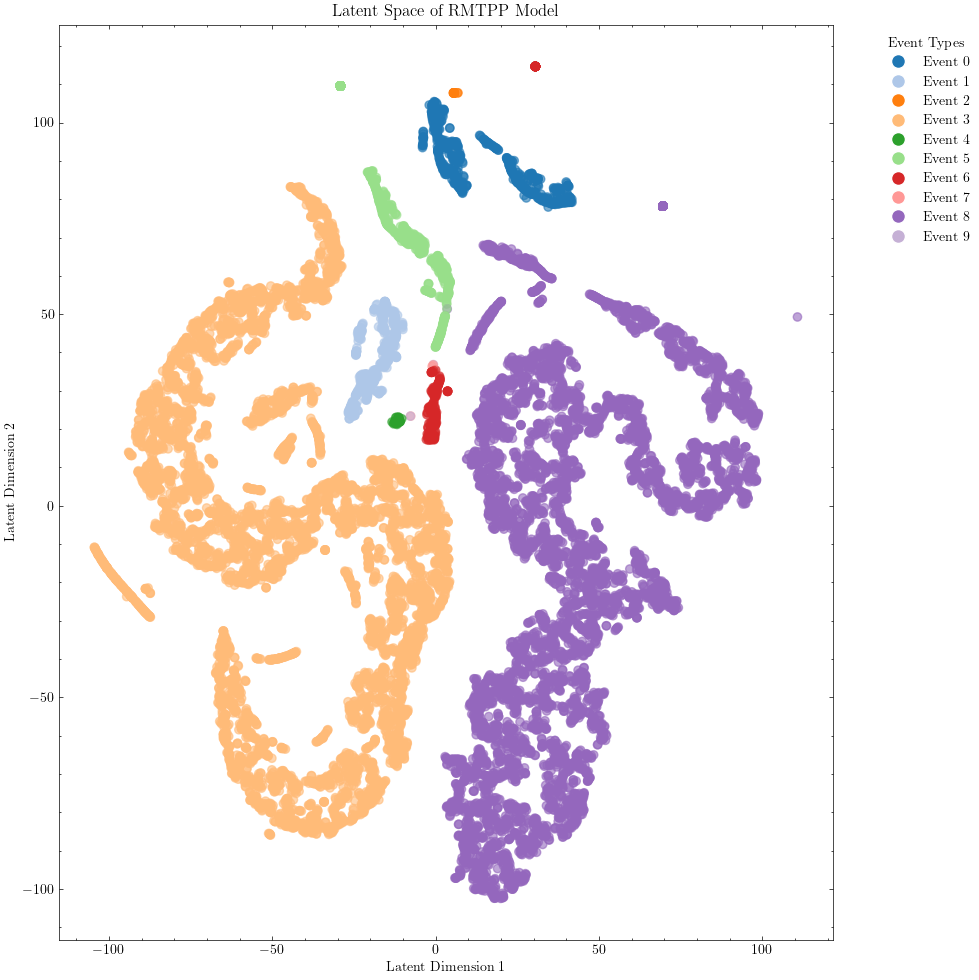

In [51]:
plot_latent_space_tpp(tpp_model, test_loader, device)